In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import plotly
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder 
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.multioutput import MultiOutputClassifier # Multi Output Classifier
from sklearn.ensemble import RandomForestClassifier # RandomForest Classifier
from sklearn.ensemble import GradientBoostingClassifier # GradientBoost Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import re 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from datasets import Dataset

In [2]:
df = pd.read_csv('all-data.csv', encoding='Latin-1', names=['sentiment', 'text'])

# Map sentiment to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

# Display class distribution
print(df['label'].value_counts())

label
1    2879
2    1363
0     604
Name: count, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

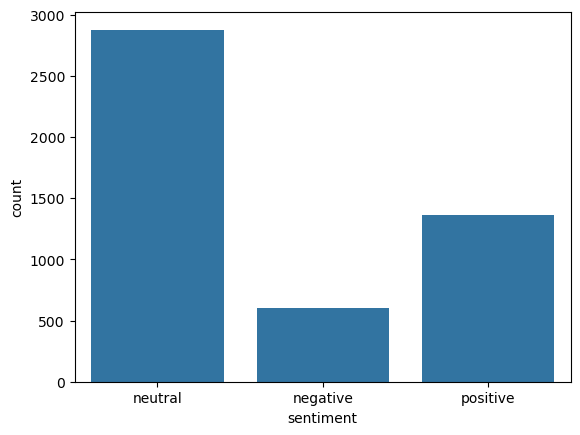

In [3]:
sns.countplot(data=df,x='sentiment')

In [6]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install -U transformers

Defaulting to user installation because normal site-packages is not writeable


In [10]:
pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [42]:
#Clean and preprocess text data by removing special characters, converting to lowercase, removing stopwords, and applying stemming.
def text_clean(data):
    corpus = []
    for i in range(len(data)):
        review = re.sub("[^a-zA-Z0-9]"," ",data[i])
        review = review.lower()
        review = review.split()
        review = [stemmer.stem(words) for words in review if words not in set(stopwords.words('english'))]
        review = " ".join(review)
        corpus.append(review)
    return corpus

In [43]:
Y = df['sentiment']
X = df['text']

In [44]:
stemmer = PorterStemmer()

In [45]:
X = text_clean(X)
X = np.array(X)

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [47]:
print(X_train.shape,X_test.shape,y_train.shape)

(3876,) (970,) (3876,)


In [48]:
## Initialize the CountVectorizer to convert text data into a matrix of token count
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [49]:
regressor = LogisticRegression(max_iter=5000)
regressor.fit(X_train_vectorized,y_train)

x_test_pred = regressor.predict(X_test_vectorized)
x_test_accuracy = accuracy_score(x_test_pred,y_test)

print("The accuracy of test set is: {}".format(x_test_accuracy))

The accuracy of test set is: 0.756701030927835


In [50]:
models = {
    "GradientBoosting":GradientBoostingClassifier()
}
params = {
    "GradientBoosting":{}
}

In [51]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_vectorized,y_train)

x_test_pred = gbc.predict(X_test_vectorized)
x_test_accuracy = accuracy_score(x_test_pred,y_test)

print("The accuracy of test set is: {}".format(x_test_accuracy))

The accuracy of test set is: 0.7628865979381443


In [2]:
#Real-Time Financial News Sentiment Analysis
from newsapi import NewsApiClient
import pandas as pd

# Initialize
newsapi = NewsApiClient(api_key='33e89d06e44442c5b535cfbc38e8767c')  # Replace with your API key

# Get top financial headlines
news = newsapi.get_everything(q='stocks OR market OR finance',
                              language='en',
                              sort_by='publishedAt',
                              page_size=50)

# Convert to DataFrame
news_df = pd.DataFrame([{
    'title': article['title'],
    'description': article['description'],
    'publishedAt': article['publishedAt']
} for article in news['articles']])

news_df.dropna(subset=['description'], inplace=True)
news_df.reset_index(drop=True, inplace=True)

news_df.head()

,title,description,publishedAt
0,Former SafeMoon CEO Braden Karony convicted on...,A federal jury convicted former SafeMoon Brade...,2025-05-23T22:02:30Z
1,Khosla Ventures among VCs experimenting with A...,VC firms are pioneering a new investment strat...,2025-05-23T22:01:32Z
2,Lawyer Who Sued Federal Health Agency To Relea...,An attorney with a history of suing top federa...,2025-05-23T22:00:33Z
3,CME Group Bets Big On XRP—Institutional Demand...,CME Group’s quiet confidence in XRP has crysta...,2025-05-23T22:00:27Z
4,Ethereum Holds Above Key Prices – Data Points ...,Ethereum is at a critical juncture as it appro...,2025-05-23T22:00:27Z


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply sentiment analysis to descriptions
news_df['sentiment'] = news_df['description'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

news_df[['publishedAt', 'title', 'sentiment']].head()

Device set to use cpu


,publishedAt,title,sentiment
0,2025-05-23T22:02:30Z,Former SafeMoon CEO Braden Karony convicted on...,neutral
1,2025-05-23T22:01:32Z,Khosla Ventures among VCs experimenting with A...,positive
2,2025-05-23T22:00:33Z,Lawyer Who Sued Federal Health Agency To Relea...,neutral
3,2025-05-23T22:00:27Z,CME Group Bets Big On XRP—Institutional Demand...,neutral
4,2025-05-23T22:00:27Z,Ethereum Holds Above Key Prices – Data Points ...,positive


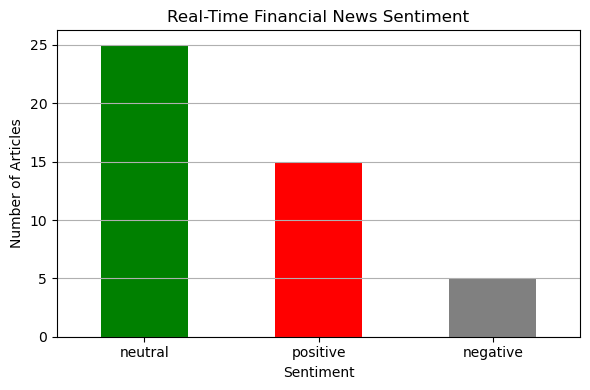

In [5]:
import matplotlib.pyplot as plt

sentiment_counts = news_df['sentiment'].value_counts()

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Real-Time Financial News Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()